In [1]:
'''
Usage:
1. Directory with data sets must be placed in directory named "input"
2. Input directory must be in the same directory as the .ipynb file with this sript
3. Inside each data set directory there must be three directories named: images, labels and masks.
4. Filenames of labels and masks files must be the same as image filename.
'''

'\nUsage:\n1. Directory with data sets must be placed in directory named "input"\n2. Input directory must be in the same directory as the .ipynb file with this sript\n3. Inside each data set directory there must be three directories named: images, labels and masks.\n4. Filenames of labels and masks files must be the same as image filename.\n'

In [2]:
#!/usr/bin/env python
# coding: utf-8


import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from PIL import Image
import cv2
from datetime import datetime
import tensorflow as tf
import argparse

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D, Input, concatenate
from keras import backend as K
#import tensorflow as tf
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
from keras.callbacks import ModelCheckpoint
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance


data_gen_args = dict(
        rotation_range=10.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=10,
        zoom_range=0.2,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest'
)

def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap = 'gray')
    plt.show()

def get_augmented(
    X_train, 
    Y_train, 
    X_val=None,
    Y_val=None,
    batch_size=32, 
    seed=0, 
    data_gen_args = dict(
        rotation_range=10.,
        width_shift_range=0.02,
        height_shift_range=0.02,
        zca_whitening = False,
        zca_epsilon = 1e-6,
        shear_range=5,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )):


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen_1 = ImageDataGenerator(**data_gen_args)
    Y_datagen_2 = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_train_1 = Y_train[:,:,:,0:1]
    Y_train_2 = Y_train[:,:,:,1:2]
    Y_datagen_1.fit(Y_train_1, augment=True, seed=seed)
    Y_datagen_2.fit(Y_train_2, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented_1 = Y_datagen_1.flow(Y_train_1, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented_2 = Y_datagen_2.flow(Y_train_2, batch_size=batch_size, shuffle=True, seed=seed)
    
    train_generator = zip(X_train_augmented, Y_train_augmented_1, Y_train_augmented_2)#, Y_train_augmented_3)
    return train_generator

def my_generator(
    X_train, 
    Y_train,
    train_gen,
    X_val=None,
    Y_val=None,
    batch_size=2, 
    seed=0, 
    data_gen_args = dict(
        rotation_range=10.,
        width_shift_range=0.02,
        height_shift_range=0.02,
        zca_whitening = False,
        zca_epsilon = 1e-6,
        shear_range=5,
        zoom_range=0.3,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest'
    )):
    while 1:
        sample_batch = next(train_gen)
        xx, yy1,yy2 = sample_batch
        yy = np.zeros((xx.shape[0],xx.shape[1],xx.shape[2],2),dtype=np.float32)
        yy[:,:,:,0:1] = yy1
        yy[:,:,:,1:2] = yy2
#        yy[:,:,:,6:7] = yy3
        yield (xx, yy)


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)

def conv2d_block(
    inputs, 
    filters=16, 
    kernel_size=(3,3), 
    activation='tanh', 
#    kernel_initializer='he_normal', 
    kernel_initializer= 'glorot_uniform',
    padding='same'):
    
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (inputs)
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (c)
    return c

def my_custom_unet(
    input_shape,
    num_classes=1,
    upsample_mode='deconv', # 'deconv' or 'simple' 
    filters=16,
    num_layers=4,
    output_activation='softmax'): # 'sigmoid' or 'softmax'
    
    if upsample_mode=='deconv':
        upsample=upsample_conv
    else:
        upsample=upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    x = inputs   

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(inputs=x, filters=filters)
        down_layers.append(x)
        x = MaxPooling2D((2, 2)) (x)
        filters = filters*2 # double the number of filters with each layer

    x = conv2d_block(inputs=x, filters=196)


    for conv in reversed(down_layers):        
        filters //= 2 # decreasing number of filters with each layer 
        x = upsample(filters, (2, 2), strides=(2, 2), padding='same') (x)
        x = concatenate([x, conv])
        x = conv2d_block(inputs=x, filters=filters)
    
    outputs = Conv2D(num_classes, (1, 1), activation=output_activation) (x)    

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def train_UNET(graphs_train, graphs_test):
    images_train = list()
    for graph in graphs_train:
        images_train.append(f"{IMAGES_DIR_PATH}/{graph.file_id}.bmp")

    masks = glob.glob(f"{MASKS_DIR_PATH}/*.bmp")
    orgs = glob.glob(f"{IMAGES_DIR_PATH}/*.bmp")

    masks.sort()
    orgs.sort()

    list_train = []
    list_test =  []

    for (i, org) in enumerate(orgs):
        for (j, img_train) in enumerate(images_train):
            if org == img_train:
                list_train.append(i)
                break
            elif j == len(images_train)-1:
                list_test.append(i)
                
    print(len(list_train))
    print(len(list_test))
    print(len(masks))
    print(len(orgs))

    imgs_list = []
    masks_list = []

    size = (128,128)

    for image, mask in zip(orgs, masks):
        im = cv2.imread(image)
        im = im[:,:,0]
        imgs_list.append(im)

        im = cv2.imread(mask)
        im = im[:,:,0]

        imMask = np.zeros((im.shape[0],im.shape[1],2),dtype=np.float32)
        imMask[im == 0,0] = 1               #background
        imMask[im!=0,1] = 1                 #spine

        masks_list.append(imMask)

 
        
    imgs_np = np.asarray(imgs_list)
    masks_np = np.asarray(masks_list)
    print(imgs_np.shape, masks_np.shape)

    weights = np.ones((2),dtype=np.float32)
    for i in range(0,2):
        weights[i] = 1/(np.sum(masks_np[:,:,:,i])/(masks_np.shape[0]*masks_np.shape[1]*masks_np.shape[2]))

    w = sum(weights)
    weights = weights/w

    print(weights)

    print(imgs_np.max(), masks_np.max())
    x = np.asarray(imgs_np, dtype=np.float32)
    y = np.asarray(masks_np, dtype=np.float32)
    print(x.max(), y.max())
    print(x.shape, y.shape)
    y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 2)
    print(x.shape, y.shape)
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    print(x.shape, y.shape)

    list_val = list_train[:int(0.2*len(list_train))]
    list_train = list_train[int(0.2*len(list_train)):]

    print(list_train)
    print(list_val)
    print(list_test)

    x_train = x[list_train]
    x_val = x[list_val]
    x_test = x[list_test]

    y_train = y[list_train]
    y_val = y[list_val]
    y_test = y[list_test]

    print("x_train: ", x_train.shape)
    print("y_train: ", y_train.shape)
    print("x_val: ", x_val.shape)
    print("y_val: ", y_val.shape)
    print("x_test: ", x_test.shape)
    print("y_test: ", y_test.shape)

    input_shape = x_train[0].shape
    model = my_custom_unet(
            input_shape,
            num_classes=2,
            filters=64,
            output_activation='softmax',
            num_layers=4  
    )
    
    if not os.path.exists(f"saved_objects/unet"):


        model_filename = f"saved_objects/unet"

        callback_checkpoint = ModelCheckpoint(
            model_filename, 
            verbose=1, 
            monitor='val_loss', 
            save_best_only=True
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
            loss = weighted_categorical_crossentropy(weights),
            metrics=[iou]
        )

        model.summary()

        train_gen = get_augmented(x_train, y_train, batch_size=2,data_gen_args=data_gen_args)
        generator = my_generator(x_train, y_train,train_gen, batch_size=2,data_gen_args=data_gen_args)

        history = model.fit_generator(
            generator,
            steps_per_epoch=30,
            epochs=150,
            validation_data=(x_val, y_val),
            callbacks=[callback_checkpoint]
        )


    model.load_weights(f"saved_objects/unet")
    
    GENERATED_UNET_DIR_PATH = f"{OUTPUT_DIR_PATH}/generated_unet"
    if os.path.exists(GENERATED_UNET_DIR_PATH):
        shutil.rmtree(GENERATED_UNET_DIR_PATH)
    os.makedirs(GENERATED_UNET_DIR_PATH)
    
    for N in range(x_test.shape[0]):
        y_pred = model.predict(x_test[N:N+1])
        predictions = np.round(y_pred)
        for k in range(1,2):
            dum = predictions[0,:,:,k]*255
            filename = os.path.basename(orgs[list_test[N]])[:-4]
            cv2.imwrite(f"{GENERATED_UNET_DIR_PATH}/{filename}.png",dum)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
import numpy as np
import os
import collections
import matplotlib.pyplot as plt
import skimage.future.graph as skigraph
import shutil
import pickle
import keras
import tensorflow as tf
import networkx as nx
import time
import sys
import shutil
from sklearn.metrics import confusion_matrix
from keras import backend as K

from kgcnn.literature.GraphSAGE import make_model
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from kgcnn.utils.learning import LinearLearningRateScheduler
from PIL import Image, ImageOps
import radiomics
import numpy.ma as ma
import nrrd
import warnings
from collections import defaultdict
import logging

In [4]:
# script parameterss
DATA_SET_DIR_NAMES = [
    #"250_pixel_15_com",
    #"250_pixel_25_com",
    #"250_pixel_35_com",
    "300_pixel_10_com",  
    #"300_pixel_20_com",  
    #"300_pixel_30_com",  
    #"300_pixel_40_com",
    #"250_pixel_20_com",
    #"250_pixel_30_com", 
    #"250_pixel_40_com",  
    #"300_pixel_15_com",  
    #"300_pixel_25_com", 
    #"300_pixel_35_com",  
    #"300_pixel_5_com"
]
PYRADIOMICS_FEATURES = [
    "original_firstorder_Mean",
    "original_firstorder_10Percentile",
    "original_firstorder_90Percentile",

    "original_firstorder_Entropy",
    "original_firstorder_InterquartileRange",
    "original_firstorder_Kurtosis",
    "original_firstorder_Maximum",
    "original_firstorder_MeanAbsoluteDeviation",
    "original_firstorder_Median",
    "original_firstorder_Minimum",
    "original_firstorder_Range",
    "original_firstorder_RobustMeanAbsoluteDeviation",
    "original_firstorder_RootMeanSquared",
    "original_firstorder_Skewness",
    "original_firstorder_Uniformity",
    "original_firstorder_Variance",
    "original_glcm_Autocorrelation",
    "original_glcm_ClusterProminence",
    "original_glcm_ClusterShade",
    "original_glcm_ClusterTendency",
    "original_glcm_Contrast",
    "original_glcm_Correlation",
    "original_glcm_DifferenceAverage",
    "original_glcm_DifferenceEntropy",
    "original_glcm_DifferenceVariance",
    "original_glcm_Id",
    "original_glcm_Idm",
    "original_glcm_Idmn",
    "original_glcm_Idn",
    "original_glcm_Imc1",
    "original_glcm_Imc2",
    "original_glcm_InverseVariance",
    "original_glcm_JointAverage",
    "original_glcm_JointEnergy",
    "original_glcm_JointEntropy",
    "original_glcm_MCC",
    "original_glcm_MaximumProbability",
    "original_glcm_SumAverage",
    "original_glcm_SumEntropy",
    "original_glcm_SumSquares",
    "original_gldm_DependenceEntropy",
    "original_gldm_DependenceNonUniformity",
    "original_gldm_DependenceNonUniformityNormalized",
    "original_gldm_DependenceVariance",
    "original_gldm_GrayLevelNonUniformity",
    "original_gldm_GrayLevelVariance",
    "original_gldm_HighGrayLevelEmphasis",
    "original_gldm_LargeDependenceEmphasis",
    "original_gldm_LargeDependenceLowGrayLevelEmphasis",
    "original_gldm_LowGrayLevelEmphasis",
    "original_gldm_SmallDependenceHighGrayLevelEmphasis",
    "original_gldm_SmallDependenceLowGrayLevelEmphasis",
    "original_glrlm_GrayLevelNonUniformity",
    "original_glrlm_GrayLevelNonUniformityNormalized",
    "original_glrlm_GrayLevelVariance",
    "original_glrlm_HighGrayLevelRunEmphasis",
    "original_glrlm_LongRunEmphasis",
    "original_glrlm_LongRunHighGrayLevelEmphasis",
    "original_glrlm_LongRunLowGrayLevelEmphasis",
    "original_glrlm_LowGrayLevelRunEmphasis",
    "original_glrlm_RunLengthNonUniformity",
    "original_glrlm_RunLengthNonUniformityNormalized",
    "original_glrlm_RunPercentage",
    "original_glrlm_RunVariance",
    "original_glrlm_ShortRunEmphasis",
    "original_glrlm_ShortRunHighGrayLevelEmphasis",
    "original_glrlm_ShortRunLowGrayLevelEmphasis",
    "original_glszm_GrayLevelNonUniformity",
    "original_glszm_GrayLevelNonUniformityNormalized",
    "original_glszm_GrayLevelVariance",
    "original_glszm_HighGrayLevelZoneEmphasis",
    "original_glszm_LargeAreaEmphasis",
    "original_glszm_LargeAreaHighGrayLevelEmphasis",
    "original_glszm_LargeAreaLowGrayLevelEmphasis",
    "original_glszm_LowGrayLevelZoneEmphasis",
    "original_glszm_SizeZoneNonUniformity",
    "original_glszm_SizeZoneNonUniformityNormalized",
    "original_glszm_SmallAreaEmphasis",
    "original_glszm_SmallAreaLowGrayLevelEmphasis",
    "original_glszm_ZoneEntropy",
    "original_glszm_ZonePercentage",
    "original_glszm_ZoneVariance",
    "original_ngtdm_Busyness",
    "original_ngtdm_Coarseness",
    "original_ngtdm_Complexity",
    "original_ngtdm_Contrast",
    "original_ngtdm_Strength",
]

WHITE_SUPERPIXEL_LABEL_TRESHOLD = 0.65

#configuration
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

In [5]:
# utils
def save_object(filename, obj):
    obj_file = open(filename, "wb")
    pickle.dump(obj, obj_file)
    obj_file.close()
    
def load_object(filename):
    obj_file = open(filename, "rb")
    obj = pickle.load(obj_file)
    obj_file.close()
    
    return obj

# semantic segmentation using subgraphs of image graphs
class Graph:
    def __init__(self, file_id, rag, image, superpixels_labels, mask):
        self.file_id = file_id
        self.rag = rag
        self.image = image
        self.superpixels_labels = superpixels_labels
        self.mask = mask

class Subgraph:
    def __init__(self, rag, graph, middle_superpixel_label, label):
        self.rag = rag
        self.graph = graph
        self.middle_superpixel_label = middle_superpixel_label
        self.label = label
        self.unnormalized_edge_indices = None
        self.normalized_edge_indices = None
        self.edges = None
        self.nodes = None
        
def assign_label(graph):
    white_pixels_count = defaultdict(int)
    total_pixels_count = defaultdict(int)
    
    for (i, row) in enumerate(graph.superpixels_labels):
        for (j, superpixel_label) in enumerate(row):
            total_pixels_count[superpixel_label] += 1
            if graph.mask[i][j] == 1:
                white_pixels_count[superpixel_label] += 1
      
    for node in graph.rag:
        graph.rag.nodes[node]['label'] = 1.0 if white_pixels_count[node] / total_pixels_count[node] >= WHITE_SUPERPIXEL_LABEL_TRESHOLD else 0.0
            
            
def assign_features(graph):
    unique_superpixels_labels = np.unique(graph.superpixels_labels)
    
    for superpixel_label in unique_superpixels_labels:
        superpixel_label_mask = (graph.superpixels_labels == superpixel_label).astype(int)
        NRRD_DIRECTORY_PATH = f"{OUTPUT_DIR_PATH}/nrrd"
        NRRD_ITEM_DIRECTORY_PATH = f"{NRRD_DIRECTORY_PATH}/{graph.file_id}"
        os.makedirs(NRRD_ITEM_DIRECTORY_PATH, exist_ok=True)
        
        os.makedirs(f"{NRRD_ITEM_DIRECTORY_PATH}", exist_ok=True)
        nrrd.write(f"{NRRD_ITEM_DIRECTORY_PATH}/{superpixel_label}_image.nrrd", graph.image)
        nrrd.write(f"{NRRD_ITEM_DIRECTORY_PATH}/{superpixel_label}_superpixel_label_mask.nrrd", superpixel_label_mask)
        nrrd_image_path = os.path.join(f"{NRRD_ITEM_DIRECTORY_PATH}", str(superpixel_label) + "_image.nrrd")
        nrrd_superpixel_label_mask_path = os.path.join(f"{NRRD_ITEM_DIRECTORY_PATH}", str(superpixel_label) + "_superpixel_label_mask.nrrd")
        
        extractor = radiomics.featureextractor.RadiomicsFeatureExtractor(minimumROIDimensions=1)
        result = extractor.execute(nrrd_image_path, nrrd_superpixel_label_mask_path) 

        for feature in PYRADIOMICS_FEATURES:
            graph.rag.nodes[superpixel_label][feature] = result[feature]
    
def process_images():
    EXPECTED_DIR_PATH = f"{OUTPUT_DIR_PATH}/expected"
    if os.path.exists(EXPECTED_DIR_PATH):
        shutil.rmtree(EXPECTED_DIR_PATH)
    os.makedirs(EXPECTED_DIR_PATH)
    
    filenames = os.listdir(IMAGES_DIR_PATH)
    graphs = list()
        
    for (file_count, filename) in enumerate(filenames, start=1):
        print(f"Processing files: {file_count}/{len(filenames)}")
        
        file_id = os.path.splitext(filename)[0]
        
        try:
            image = np.array(ImageOps.grayscale(Image.open(f"{IMAGES_DIR_PATH}/{filename}")))
            mask = np.array(ImageOps.grayscale(Image.open(f"{MASKS_DIR_PATH}/{file_id}.bmp")))
            superpixels_labels = np.fromfile(f"{SUPERPIXELS_LABELS_DIR_PATH}/{file_id}.dat", dtype=np.dtype((np.int32, image.shape)))[0]
        except FileNotFoundError as error: 
            print(error)
            
        rag = skigraph.rag_mean_color(image, superpixels_labels)
        graphs.append(Graph(file_id, rag, image, superpixels_labels, mask))
        assign_label(graphs[-1])
        assign_features(graphs[-1])
        
        expected = Image.fromarray((mask*255).astype(np.uint8))
        expected.save(f"{EXPECTED_DIR_PATH}/{file_id}.png")
        
    print("All files have been processed")
    
    return graphs

def split_into_subgraphs(graphs):
    subgraphs = []
    for graph in graphs:
        for node in graph.rag.nodes:
            nodes = [neighbor for neighbor in graph.rag.neighbors(node)] + [node]
            rag = graph.rag.subgraph(nodes)
            label = graph.rag.nodes[node]['label']
            subgraphs.append(Subgraph(rag, graph, node, label))
            
    return subgraphs

def normalize_edge_indices(edge_indices):
    flat_list = [node for edge_index in edge_indices for node in edge_index]            
    flat_list.sort()
    flat_list = list(dict.fromkeys(flat_list))
    change = {key:value for (value, key) in enumerate(flat_list)}
    result = [[change[edge_index[0]], change[edge_index[1]]] for edge_index in edge_indices] 
    
    return result

def prepare_data(subgraphs):
    nodes = []
    edge_indices = []
    edges = []
    labels = []
    
    for subgraph in subgraphs:
        node_features = []
        
        for node in subgraph.rag.nodes:
            node_features.append([subgraph.rag.nodes[node][feature] for feature in PYRADIOMICS_FEATURES])
            
        nodes.append(node_features)
        edges.append([[1.0] for edge in subgraph.rag.edges.data()])
        unnormalized_edge_indices = [list(index) for index in subgraph.rag.edges]
        edge_indices.append(normalize_edge_indices(unnormalized_edge_indices))
        labels.append(subgraph.label)
        
        subgraph.nodes = nodes[-1]
        subgraph.unnormalized_edge_indices = unnormalized_edge_indices
        subgraph.normalized_edge_indices = edge_indices[-1]
        subgraph.edges = edges[-1]

    return nodes, edge_indices, edges, np.array(labels)

def generate_segmented_images_from_predictions(subgraphs, predictions):
    predicted_images = {}
    GENERATED_DIR_PATH = f"{OUTPUT_DIR_PATH}/generated"
    if os.path.exists(GENERATED_DIR_PATH):
        shutil.rmtree(GENERATED_DIR_PATH)
    os.makedirs(GENERATED_DIR_PATH)

    for (prediction_count, subgraph) in enumerate(subgraphs):
        if subgraph.graph.file_id not in predicted_images:
            predicted_images[subgraph.graph.file_id] = np.copy(subgraph.graph.superpixels_labels)
        predicted_images[subgraph.graph.file_id][predicted_images[subgraph.graph.file_id] == subgraph.middle_superpixel_label] = predictions[prediction_count] - 2

    for file_id in predicted_images.keys():
        predicted_images[file_id][predicted_images[file_id] == -1] = 255
        predicted_images[file_id][predicted_images[file_id] == -2] = 0
        generated = Image.fromarray(predicted_images[file_id].astype(np.uint8))
        generated.save(f"{GENERATED_DIR_PATH}/{file_id}.png")

def compute_dice_coefficient(expected, generated):
    expected[expected!=0] = 1
    generated[generated!=0] = 1
    
    return 2*np.sum(expected*generated)/(np.sum(expected)+np.sum(generated))

def compute_dice_coefficients_for_test_set(graphs_test, info_file):
    info_file.write(f"\t\tGCN\t\t\tUNET\n")
    for graph in graphs_test:
        expected = np.array(ImageOps.grayscale(Image.open(f"{OUTPUT_DIR_PATH}/expected/{graph.file_id}.png")))
        generated = np.array(ImageOps.grayscale(Image.open(f"{OUTPUT_DIR_PATH}/generated/{graph.file_id}.png")))
        generated_unet = np.array(ImageOps.grayscale(Image.open(f"{OUTPUT_DIR_PATH}/generated_unet/{graph.file_id}.png")))
        
        dice_coefficient = compute_dice_coefficient(expected, generated)
        dice_coefficient_unet = compute_dice_coefficient(expected, generated_unet)
        
        info_file.write(f"{graph.file_id}\t{str(dice_coefficient)}\t{str(dice_coefficient_unet)}\n")
  
def train_GCN(graphs, info_file, graphs_train, graphs_test, use_saved_model):
    subgraphs_train = split_into_subgraphs(graphs_train)
    subgraphs_test = split_into_subgraphs(graphs_test)

    nodes_train, edge_indices_train, edges_train, labels_train =  prepare_data(subgraphs_train)
    nodes_test, edge_indices_test, edges_test, labels_test =  prepare_data(subgraphs_test)

    nodes_train = ragged_tensor_from_nested_numpy(nodes_train)
    edges_train = ragged_tensor_from_nested_numpy(edges_train)
    edge_indices_train = ragged_tensor_from_nested_numpy(edge_indices_train)

    nodes_test = ragged_tensor_from_nested_numpy(nodes_test)
    edges_test = ragged_tensor_from_nested_numpy(edges_test)
    edge_indices_test = ragged_tensor_from_nested_numpy(edge_indices_test)

    xtrain = nodes_train, edges_train, edge_indices_train
    xtest = nodes_test, edges_test, edge_indices_test
    ytrain = labels_train
    ytest = labels_test
    print([x.shape for x in xtrain])
    print([x.shape for x in xtest])
    print(ytrain.shape, ytest.shape)
    info_file.write(f"nodes_train: {xtrain[0].shape}\n")
    info_file.write(f"edges_train: {xtrain[1].shape}\n")
    info_file.write(f"edge_indices_train: {xtrain[2].shape}\n")
    info_file.write(f"labels_train: {ytrain.shape}\n")
    info_file.write(f"nodes_test: {xtest[0].shape}\n")
    info_file.write(f"edges_test: {xtest[1].shape}\n")
    info_file.write(f"edge_indices_test: {xtest[2].shape}\n")
    info_file.write(f"labels_test: {ytest.shape}\n")
    
    MODEL_FILE_PATH = f"{SAVED_OBJECTS_DIR_PATH}/model"
    if os.path.exists(MODEL_FILE_PATH) and use_saved_model:
        model = keras.models.load_model(MODEL_FILE_PATH)
    else:
        model = make_model(
            name= "GraphSAGE",
            inputs= [{'shape': (None,len(PYRADIOMICS_FEATURES)), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
                    {'shape': (None,), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
                    {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
            input_embedding= {"node": {"input_dim": 95, "output_dim": 64},
                              "edge": {"input_dim": 5, "output_dim": 64}},
            output_embedding= 'graph',
            output_mlp= {"use_bias": [True, True, False], "units": [25, 10, 1],
                         "activation": ['relu', 'relu', 'sigmoid']},
            node_mlp_args= {"units": [100, 50], "use_bias": True, "activation": ['relu', "linear"]},
            pooling_args= {'pooling_method': "segment_mean"}, gather_args= {},
            concat_args= {"axis": -1},
            use_edge_features= False,
            pooling_nodes_args= {'pooling_method': "mean"},
            depth= 1, 
            verbose= 1
        )

        learning_rate_start = 1e-3
        learning_rate_stop = 1e-4
        epo = 50
        epomin = 100
        epostep = 10

        optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
        cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      weighted_metrics=['accuracy'])
        print(model.summary())

        start = time.process_time()
        hist = model.fit(xtrain, ytrain,
                         epochs=epo,
                         batch_size=32,
                         callbacks=[cbks],
                         validation_freq=epostep,
                         validation_data=(xtest, ytest),
                         verbose=2
                         )
        stop = time.process_time()
        print("Print Time for taining: ", stop - start)

        trainlossall = np.array(hist.history['accuracy'])
        testlossall = np.array(hist.history['val_accuracy'])
        acc_valid = testlossall[-1]

        plt.figure()
        plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
        plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
        plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Interaction Network Loss')
        plt.legend(loc='upper right', fontsize='x-large')
        
        TRAINING_PLOT_FILE_PATH = f"{OUTPUT_DIR_PATH}/training_plot.png"
        if os.path.exists(TRAINING_PLOT_FILE_PATH):
            os.remove(TRAINING_PLOT_FILE_PATH)
        plt.savefig(TRAINING_PLOT_FILE_PATH)
        plt.show()

        model.save(MODEL_FILE_PATH)
    
    probability = model.predict(xtest)
    predictions = np.round(probability)
    print(confusion_matrix(ytest, predictions))
    info_file.write(np.array2string(confusion_matrix(ytest, predictions))+"\n")
    generate_segmented_images_from_predictions(subgraphs_test, predictions)

def initialize_dir_paths(data_set_dir_name):
    # globals
    global DATA_DIR_PATH 
    global IMAGES_DIR_PATH
    global SUPERPIXELS_LABELS_DIR_PATH
    global MASKS_DIR_PATH
    global OUTPUT_DIR_PATH
    global SAVED_OBJECTS_DIR_PATH
    
    DATA_DIR_PATH = f"./input/{data_set_dir_name}"
    IMAGES_DIR_PATH = f"{DATA_DIR_PATH}/images"
    SUPERPIXELS_LABELS_DIR_PATH = f"{DATA_DIR_PATH}/superpixels_labels"
    MASKS_DIR_PATH = f"{DATA_DIR_PATH}/masks"
    
    OUTPUT_DIR_PATH = f"./output/{data_set_dir_name}"
    SAVED_OBJECTS_DIR_PATH = f"./saved_objects/{data_set_dir_name}"
    
def process_data_set(data_set_dir_name, use_saved_graphs=True, use_saved_model=True):  
    initialize_dir_paths(data_set_dir_name)
    os.makedirs(f"{OUTPUT_DIR_PATH}", exist_ok=True)
    os.makedirs(f"{SAVED_OBJECTS_DIR_PATH}", exist_ok=True)
    
    GRAPHS_FILE_PATH = f"{SAVED_OBJECTS_DIR_PATH}/graphs"
    if os.path.exists(GRAPHS_FILE_PATH) and use_saved_graphs:
        graphs = load_object(GRAPHS_FILE_PATH)
    else:
        graphs = process_images()
        save_object(GRAPHS_FILE_PATH, graphs)

    graphs_train, graphs_test = train_test_split(graphs, train_size=0.8, random_state=1)

    INFO_FILE_PATH = f"{OUTPUT_DIR_PATH}/info.txt"
    if os.path.exists(INFO_FILE_PATH):
        os.remove(INFO_FILE_PATH)
    with open(INFO_FILE_PATH,"w+") as info_file:
        info_file.write(f"data set directory name: {data_set_dir_name}\n")
        
        train_GCN(graphs, info_file, graphs_train, graphs_test, use_saved_model)
        train_UNET(graphs_train, graphs_test)
        compute_dice_coefficients_for_test_set(graphs_test, info_file)
    
def process_data_sets(use_saved_graphs=True, use_saved_model=True):
    for data_set_dir_name in DATA_SET_DIR_NAMES:
        process_data_set(data_set_dir_name, use_saved_graphs, use_saved_model)

In [6]:
            '''
            name = "GCN",
            inputs = [{'shape': (None, len(PYRADIOMICS_FEATURES)), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
                    {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
                    {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
            input_embedding = {"node": {"input_dim": 300, "output_dim": 400},
                               "edge": {"input_dim": 10, "output_dim": 64}},
            output_embedding =  'graph',
            output_mlp = {"use_bias": [True, True, False], "units": [140, 70, 1],
                        "activation": ['relu', 'relu', 'sigmoid']},
            gcn_args = {"units": 64, "use_bias": False, "activation": 'relu', "pooling_method": 'sum', 
                        "normalize_by_weights": False},
            depth = 1
            '''

'\nname = "GCN",\ninputs = [{\'shape\': (None, len(PYRADIOMICS_FEATURES)), \'name\': "node_attributes", \'dtype\': \'float32\', \'ragged\': True},\n        {\'shape\': (None, 1), \'name\': "edge_attributes", \'dtype\': \'float32\', \'ragged\': True},\n        {\'shape\': (None, 2), \'name\': "edge_indices", \'dtype\': \'int64\', \'ragged\': True}],\ninput_embedding = {"node": {"input_dim": 300, "output_dim": 400},\n                   "edge": {"input_dim": 10, "output_dim": 64}},\noutput_embedding =  \'graph\',\noutput_mlp = {"use_bias": [True, True, False], "units": [140, 70, 1],\n            "activation": [\'relu\', \'relu\', \'sigmoid\']},\ngcn_args = {"units": 64, "use_bias": False, "activation": \'relu\', "pooling_method": \'sum\', \n            "normalize_by_weights": False},\ndepth = 1\n'

[TensorShape([28055, None, 87]), TensorShape([28055, None, 1]), TensorShape([28055, None, 2])]
[TensorShape([7583, None, 87]), TensorShape([7583, None, 1]), TensorShape([7583, None, 2])]
(28055,) (7583,)
INFO:kgcnn: Updated model kwargs:
{'concat_args': {'axis': -1},
 'depth': 1,
 'edge_mlp_args': {'activation': ['relu', 'linear'],
                   'units': [100, 50],
                   'use_bias': True},
 'gather_args': {},
 'input_embedding': {'edge': {'input_dim': 5, 'output_dim': 64},
                     'node': {'input_dim': 95, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 87)},
            {'dtype': 'float32',
             'name': 'edge_attributes',
             'ragged': True,
             'shape': (None,)},
            {'dtype': 'int64',
             'name': 'edge_indices',
             'ragged': True,
             'shape': (None, 2)}],
 'name': 'GraphSAGE',
 'node_mlp_a

/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_attributes (InputLayer)    [(None, None, 87)]   0                                            
__________________________________________________________________________________________________
edge_indices (InputLayer)       [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
gather_nodes_outgoing (GatherNo (None, None, 87)     0           node_attributes[0][0]            
                                                                 edge_indices[0][0]               
__________________________________________________________________________________________________
mlp (MLP)                       (None, None, 50)     13850       gather_nodes_outgoing[0][0]  

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/pooling_local_edges/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/pooling_local_edges/Reshape:0", shape=(None, 50), dtype=float32), dense_shape=Tensor("gradient_tape/model/pooling_local_edges/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


877/877 - 4s - loss: 0.2654 - accuracy: 0.8841
Epoch 2/50
877/877 - 3s - loss: 0.2077 - accuracy: 0.9125
Epoch 3/50
877/877 - 3s - loss: 0.1910 - accuracy: 0.9204
Epoch 4/50
877/877 - 3s - loss: 0.1793 - accuracy: 0.9282
Epoch 5/50
877/877 - 3s - loss: 0.1707 - accuracy: 0.9290
Epoch 6/50
877/877 - 3s - loss: 0.1663 - accuracy: 0.9311
Epoch 7/50
877/877 - 3s - loss: 0.1628 - accuracy: 0.9331
Epoch 8/50
877/877 - 3s - loss: 0.1627 - accuracy: 0.9327
Epoch 9/50
877/877 - 3s - loss: 0.1543 - accuracy: 0.9362
Epoch 10/50
877/877 - 4s - loss: 0.1538 - accuracy: 0.9359 - val_loss: 0.1350 - val_accuracy: 0.9457
Epoch 11/50
877/877 - 3s - loss: 0.1515 - accuracy: 0.9370
Epoch 12/50
877/877 - 3s - loss: 0.1484 - accuracy: 0.9377
Epoch 13/50
877/877 - 3s - loss: 0.1476 - accuracy: 0.9402
Epoch 14/50
877/877 - 3s - loss: 0.1467 - accuracy: 0.9380
Epoch 15/50
877/877 - 3s - loss: 0.1428 - accuracy: 0.9415
Epoch 16/50
877/877 - 3s - loss: 0.1415 - accuracy: 0.9421
Epoch 17/50
877/877 - 3s - loss: 0

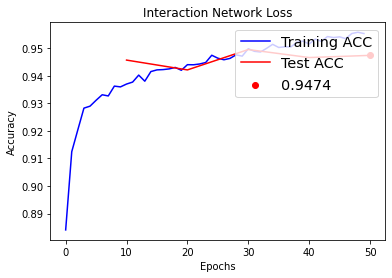

INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_10_com/model/assets


INFO:tensorflow:Assets written to: ./saved_objects/300_pixel_10_com/model/assets


[[5729  179]
 [ 220 1455]]
112
28
140
140
(140, 128, 128) (140, 128, 128, 2)
[0.22539543 0.77460456]
255 1.0
255.0 1.0
(140, 128, 128) (140, 128, 128, 2)
(140, 128, 128) (140, 128, 128, 2)
(140, 128, 128, 1) (140, 128, 128, 2)
[28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 44, 45, 46, 47, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 73, 75, 77, 78, 79, 82, 83, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 102, 104, 105, 106, 108, 109, 110, 111, 112, 114, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
[0, 2, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[1, 5, 8, 9, 17, 18, 35, 41, 43, 48, 53, 56, 65, 72, 74, 76, 80, 81, 84, 89, 99, 100, 103, 107, 113, 115, 118, 128]
x_train:  (90, 128, 128, 1)
y_train:  (90, 128, 128, 2)
x_val:  (22, 128, 128, 1)
y_val:  (22, 128, 128, 2)
x_test:  (28, 128, 128, 1)
y_test:  (28, 128, 128, 2)


In [7]:
process_data_sets(use_saved_graphs=True, use_saved_model=False)